In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
torch.cuda.device_count()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
"""
Implementation of YOLOv3 architecture
"""

import torch
import torch.nn as nn

""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
model_config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x


class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),
        )
        self.num_classes = num_classes

    def forward(self, x):
        x = (
            self.pred(x)
            .reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )
        return x


class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in model_config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers

In [3]:
# num_classes = 20
# IMAGE_SIZE = 416

# model = YOLOv3(num_classes=num_classes)

# x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
# out = model(x)

# assert model(x)[0].shape == (2, 3, IMAGE_SIZE // 32, IMAGE_SIZE // 32, num_classes + 5)
# assert model(x)[1].shape == (2, 3, IMAGE_SIZE // 16, IMAGE_SIZE // 16, num_classes + 5)
# assert model(x)[2].shape == (2, 3, IMAGE_SIZE // 8, IMAGE_SIZE // 8, num_classes + 5)

# print("Success!")

In [4]:
# from torchinfo import summary

# summary(
#     model,
#     input_data=x,
# )

In [5]:
# [batch, 25 (5 + nclasses), anchor_box, width, height]

# Explore Dataset

In [3]:
"""
Creates a Pytorch dataset to load the Pascal VOC & MS COCO datasets
"""

import config
import numpy as np
import os
import pandas as pd
import torch
from tqdm import tqdm

from PIL import Image, ImageFile
from torch.utils.data import Dataset
import torch.optim as optim


ImageFile.LOAD_TRUNCATED_IMAGES = True


class YOLODataset(Dataset):
    def __init__(
        self,
        csv_file,
        img_dir,
        label_dir,
        anchors,
        image_size=416,
        S=[13, 26, 52],
        C=20,
        transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.image_size = image_size
        self.transform = transform
        self.S = S
        
        # shape: [number of states, number of anchors, 2]
        self.anchors = torch.tensor(anchors)
        self.num_anchors_per_scale = self.anchors.shape[1]

    def __len__(self):
        return len(self.annotations)

    @staticmethod
    def iou(box, anchors):
        """
        box:
            tensor shape: [2]
        anchors:
            tensor shape: [number of states, number of anchors, 2]
            
        * 2 above is for width and height
        """

        intersection = torch.prod(torch.min(box, anchors), dim=-1)
        union = torch.prod(box) + torch.prod(anchors, dim=-1) - intersection
        return intersection / union

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        bboxes = np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), shift=-1, axis=1)

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = np.array(Image.open(img_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]

        # # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        # # 6 = [objectness, cx, cy, w, h, class]
        # targets = [torch.zeros((self.num_anchors_per_scale, 6, S, S)) for S in self.S]
        targets = [torch.zeros((self.num_anchors_per_scale, S, S, 6)) for S in self.S]

        for bbox in bboxes:
            iou = self.iou(torch.tensor(bbox[2:4]), self.anchors)

            idx = torch.argsort(iou, descending=True, dim=-1)
            idx = idx[:, 0].tolist()

            dimensions, class_ = np.array(bbox[:-1]), bbox[-1]#+1

            for scale_idx, anchor_id in enumerate(idx):
                scale_dim = self.S[scale_idx]
                scale_cx, scale_cy, scale_w, scale_h = dimensions * scale_dim
                
                row, col = int(scale_cy), int(scale_cx)

                # fill values
                scale_cx = scale_cx - col
                scale_cy = scale_cy - row

                box_target = torch.tensor(
                    [1, scale_cx, scale_cy, scale_w, scale_h, class_]
                )

                targets[scale_idx][anchor_id, row, col] = box_target

        return image, targets

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [7]:
# IMAGE_SIZE = config.IMAGE_SIZE

# train_dataset = YOLODataset(
#     config.DATASET + "/2examples.csv",
#     transform=config.train_transforms,
#     S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
#     img_dir=config.IMG_DIR,
#     label_dir=config.LABEL_DIR,
#     anchors=config.ANCHORS,
# )

# image, target = train_dataset[1]

In [4]:
from torch.utils.data import DataLoader


def get_loaders(train_csv_path, test_csv_path):
    IMAGE_SIZE = config.IMAGE_SIZE
    train_dataset = YOLODataset(
        train_csv_path,
        transform=config.train_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    test_dataset = YOLODataset(
        test_csv_path,
        transform=config.test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    train_eval_dataset = YOLODataset(
        train_csv_path,
        transform=config.test_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    train_eval_loader = DataLoader(
        dataset=train_eval_dataset,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        pin_memory=config.PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    return train_loader, test_loader, train_eval_loader

In [14]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn
import torch.nn.functional as F


class YoloLoss(nn.Module):
    def __init__(self, nclasses):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1.5
        self.lambda_noobj = 2
        self.lambda_obj = 1
        self.lambda_box = 2

        self.nclasses = nclasses

    # intersection over union
    @staticmethod
    def iou(box1, box2):
        """
        boxi shape = [any shape, 4] i.e [4] or [3,4] or [2,3,4] etc.

        * 4 = [x, y, w, h]

        output shape = [batch]
        """
        # box1 x1, x2
        box1_x1 = box1[..., 0] - box1[..., 2] / 2
        box1_x2 = box1[..., 0] + box1[..., 2] / 2

        # box2 x1, x2
        box2_x1 = box2[..., 0] - box2[..., 2] / 2
        box2_x2 = box2[..., 0] + box2[..., 2] / 2

        # the width of intersection (x)
        x1 = torch.max(box1_x1, box2_x1)
        x2 = torch.min(box1_x2, box2_x2)

        x = (x2 - x1).clamp(0)

        # box1 y1, y2
        box1_y1 = box1[..., 1] - box1[..., 3] / 2
        box1_y2 = box1[..., 1] + box1[..., 3] / 2

        # box2 y1, y2
        box2_y1 = box2[..., 1] - box2[..., 3] / 2
        box2_y2 = box2[..., 1] + box2[..., 3] / 2

        # the height of intersection (y)
        y1 = torch.max(box1_y1, box2_y1)
        y2 = torch.min(box1_y2, box2_y2)

        y = (y2 - y1).clamp(0)

        # intersection
        intersection = x * y

        # union
        area_box1 = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
        area_box2 = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

        union = area_box1 + area_box2 - intersection + 1e-6

        return intersection / union

    def forward(self, predictions, target, anchors):
        """
        predictions: [batch, 3, 13, 13, 25] where 25 = [objectness, cx, cy, w, h] + 20 classes
        target: [batch, 3, 13, 13, 6] where 6 = [objectness, cx, cy, w, h, true class]
        anchors: [3, 2]

        * 13 is S
        * 3 is number of anchors
        """
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0

        """
        both - no object and object loss
        uncomment noobj above and below for only no_object_loss)
        
        predictions shape: [batch, 3, 13, 13]
        target shape: [batch, 3, 13, 13]
        """
        no_object_loss = self.bce(
            predictions[..., 0][noobj],
            target[..., 0][noobj]
            
        )

        """
        object loss
        
        predictions[..., 0][obj] shape: [total_object_in_batch]
        target[..., 0][obj] shape: [total_object_in_batch]
        """
        object_loss = self.bce(
            predictions[..., 0][obj],
            target[..., 0][obj]
            
        )
            
        anchors = anchors.reshape(1, 3, 1, 1, 2)
        box_preds = torch.cat(
            [
                self.sigmoid(predictions[..., 1:3]),
                torch.exp(predictions[..., 3:5]) * anchors,
            ],
            dim=-1,
        )

        ious = self.iou(box_preds[obj], target[..., 1:5][obj]).detach()
        object_loss += self.mse(
            self.sigmoid(predictions[..., 0][obj]), ious * target[..., 0][obj]
        )

        """
        coordinate loss or box loss
        
        predictions[..., 1:5][obj] shape: [total_obj_in_batch, 4]
        target[..., 1:5][obj] shape: [total_obj_in_batch, 4]
        """
        # x, y coordinates
        predictions[..., 1:3] = self.sigmoid(predictions[..., 1:3])

        # width, height coordinates
        target[..., 3:5] = torch.log((1e-16 + target[..., 3:5] / anchors))
        box_loss = self.mse(predictions[..., 1:5][obj], target[..., 1:5][obj])

        """
        classification loss : cross entropy
        
        predictions[..., 5:][obj] shape: [total_obj_in_batch, nclasses]
        target[..., 5][obj].long() shape: [total_obj_in_batch]
        """
        class_loss = self.entropy(
            (predictions[..., 5:][obj]),
            (target[..., 5][obj].long()),
        )

        """
        classification loss : binary cross entropy
        
        This is my innovation: could be wrong
        Train and test without it as well.        
        """
        binary_class_loss = self.bce(
            predictions[..., 5:][obj],
            F.one_hot(target[..., 5][obj].long(), num_classes=self.nclasses).float(),
        )

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
            + self.lambda_class * class_loss
            + self.lambda_class * binary_class_loss
        )


    
if __name__ == "__main__":
    S = 13
    yl = YoloLoss(nclasses=20)
    
    predictions = torch.rand((20, 3, S, S, 25))
    
    # build target
    IMAGE_SIZE = config.IMAGE_SIZE

    train_dataset = YOLODataset(
        config.DATASET + "/train.csv",
        transform=None, #config.train_transforms,
        S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
        img_dir=config.IMG_DIR,
        label_dir=config.LABEL_DIR,
        anchors=config.ANCHORS,
    )
    _, target = train_dataset[3]
    target = target[0].unsqueeze(0) # target[0] if S=13
    target = torch.cat([target, target] * 10)
    
    # anchor
    anchor = S * train_dataset.anchors[0]
    
    print(yl(predictions, target, anchor))

tensor(8.9302)


In [6]:
def train(
    model,
    dataloader,
    optimizer,
    criterion,
    scaler,
    scaled_anchors,
    scheduler,
    objectness_threshold=0.4,
):
    model.train()
    pbar = tqdm(dataloader)

    losses = []
    
    processed_class, correct_class = 0, 0
    processed_noobj, correct_noobj = 0, 0
    processed_obj, correct_obj = 0, 0

    for batch_idx, (x, y) in enumerate(pbar):
        x = x.to(config.DEVICE)
        y = [
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        ]

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                criterion(out[0], y[0], scaled_anchors[0])
                + criterion(out[1], y[1], scaled_anchors[1])
                + criterion(out[2], y[2], scaled_anchors[2])
            )

        losses.append(loss.item())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # update progress bar
        mean_loss = sum(losses) / len(losses)

        # metric monitoring
        for i, yi in enumerate(y):
            obj = yi[..., 0] == 1
            noobj = yi[..., 0] == 0

            # class prediction
            correct_class += torch.sum(
                torch.argmax(out[i][..., 5:][obj], dim=-1) == yi[..., 5][obj]
            ).item()
            processed_class += torch.sum(obj).item()

            # objectness prediction
            obj_preds = torch.sigmoid(out[i][..., 0]) > objectness_threshold
            correct_obj += torch.sum(obj_preds[obj] == yi[..., 0][obj]).item()
            processed_obj += torch.sum(obj).item()

            # no objectness prediction
            correct_noobj += torch.sum(obj_preds[noobj] == yi[..., 0][noobj]).item()
            processed_noobj += torch.sum(noobj).item()

        class_accuracy = (correct_class / (processed_class + 1e-16)) * 100
        noobj_accuracy = (correct_noobj / (processed_noobj + 1e-16)) * 100
        obj_accuracy = (correct_obj / (processed_obj + 1e-16)) * 100

        round2 = lambda x: round(x, 2)
        pbar.set_description(
            f"Train Loss: {mean_loss}, Class Accuracy: {round2(class_accuracy)}, No Object Accuracy: {round2(noobj_accuracy)}, Object Accuracy: {round2(obj_accuracy)}"
        )

In [7]:
def test(
    model,
    dataloader,
    criterion,
    scaler,
    scaled_anchors,
    objectness_threshold=0.4,
):
    model.eval()
    pbar = tqdm(dataloader)

    losses = []

    processed_class, correct_class = 0, 0
    processed_noobj, correct_noobj = 0, 0
    processed_obj, correct_obj = 0, 0
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(pbar):
            x = x.to(config.DEVICE)
            y = [
                y[0].to(config.DEVICE),
                y[1].to(config.DEVICE),
                y[2].to(config.DEVICE),
            ]

            with torch.cuda.amp.autocast():
                out = model(x)
                loss = (
                      criterion(out[0], y[0], scaled_anchors[0])
                    + criterion(out[1], y[1], scaled_anchors[1])
                    + criterion(out[2], y[2], scaled_anchors[2])
                )

            losses.append(loss.item())

            # update progress bar
            mean_loss = sum(losses) / len(losses)

            # metric monitoring
            for i, yi in enumerate(y):
                obj = yi[..., 0] == 1
                noobj = yi[..., 0] == 0

                # class prediction
                correct_class += torch.sum(
                    torch.argmax(out[i][..., 5:][obj], dim=-1) == yi[..., 5][obj]
                ).item()
                processed_class += torch.sum(obj).item()

                # objectness prediction
                obj_preds = torch.sigmoid(out[i][..., 0]) > objectness_threshold
                correct_obj += torch.sum(obj_preds[obj] == yi[..., 0][obj]).item()
                processed_obj += torch.sum(obj).item()

                # no objectness prediction
                correct_noobj += torch.sum(obj_preds[noobj] == yi[..., 0][noobj]).item()
                processed_noobj += torch.sum(noobj).item()

            class_accuracy = 100 * correct_class / processed_class 
            noobj_accuracy = 100 * correct_noobj / processed_noobj
            obj_accuracy = 100 * correct_obj / processed_obj

            round2 = lambda x: round(x, 2)
            pbar.set_description(
                f"Test Loss: {mean_loss}, Class Accuracy: {round2(class_accuracy)}, No Object Accuracy: {round2(noobj_accuracy)}, Object Accuracy: {round2(obj_accuracy)}"
            )

In [5]:
train_csv_path = config.DATASET + "/train.csv"
test_csv_path = config.DATASET + "/test.csv"

train_loader, test_loader, train_eval_loader = get_loaders(train_csv_path, test_csv_path)

In [13]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
optimizer = optim.Adam(
    model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)
criterion = YoloLoss(config.NUM_CLASSES)
scaler = torch.cuda.amp.GradScaler()

if config.LOAD_MODEL:
    load_checkpoint(
        config.CHECKPOINT_FILE, model, optimizer, config.LEARNING_RATE
    )

scaled_anchors = (
    torch.tensor(config.ANCHORS) * torch.tensor(config.S).reshape(-1, 1, 1)
).to(config.DEVICE)

In [14]:
learning_rate = 0.001

scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=learning_rate,
            steps_per_epoch=len(train_loader),
            epochs=40,
            pct_start=0.2,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

In [12]:
for epoch in range(config.NUM_EPOCHS):
    print(f"Epoch {epoch}:")
    train(model, train_loader, optimizer, criterion, scaler, scaled_anchors, scheduler)
    test(model, test_loader, criterion, scaler, scaled_anchors)

    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimiser_state_dict": optimizer.state_dict(),
        },
        "./checkpoint_ocp/model_otc.pt",
    )


Epoch 0:


  0%|          | 0/518 [00:00<?, ?it/s]/home/qblocks/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
Train Loss: 19.02285067179028, Class Accuracy: 29.27, No Object Accuracy: 67.32, Object Accuracy: 87.31: 100%|██████████| 518/518 [10:06<00:00,  1.17s/it] 
Test Loss: 14.91297642492479, Class Accuracy: 40.55, No Object Accuracy: 86.85, Object Accuracy: 84.61: 100%|██████████| 155/155 [01:55<00:00,  1.34it/s] 


Epoch 1:


Train Loss: 14.39337428840431, Class Accuracy: 38.24, No Object Accuracy: 85.8, Object Accuracy: 88.3: 100%|██████████| 518/518 [10:25<00:00,  1.21s/it]   
Test Loss: 12.958960914611817, Class Accuracy: 46.43, No Object Accuracy: 87.37, Object Accuracy: 89.83: 100%|██████████| 155/155 [01:49<00:00,  1.41it/s]


Epoch 2:


Train Loss: 13.23811304431164, Class Accuracy: 41.71, No Object Accuracy: 86.4, Object Accuracy: 89.8: 100%|██████████| 518/518 [10:12<00:00,  1.18s/it]   
Test Loss: 12.930277252197266, Class Accuracy: 43.15, No Object Accuracy: 88.52, Object Accuracy: 86.51: 100%|██████████| 155/155 [02:00<00:00,  1.28it/s]


Epoch 3:


Train Loss: 12.365989904145938, Class Accuracy: 45.18, No Object Accuracy: 87.04, Object Accuracy: 90.23: 100%|██████████| 518/518 [10:06<00:00,  1.17s/it]
Test Loss: 13.005392739080614, Class Accuracy: 41.38, No Object Accuracy: 88.56, Object Accuracy: 90.13: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s]


Epoch 4:


Train Loss: 11.848795923947367, Class Accuracy: 47.28, No Object Accuracy: 87.58, Object Accuracy: 90.78: 100%|██████████| 518/518 [10:19<00:00,  1.20s/it]
Test Loss: 12.784960562183011, Class Accuracy: 44.64, No Object Accuracy: 89.26, Object Accuracy: 83.49: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s]


Epoch 5:


Train Loss: 11.272321702890874, Class Accuracy: 49.6, No Object Accuracy: 88.0, Object Accuracy: 91.04: 100%|██████████| 518/518 [10:17<00:00,  1.19s/it]  
Test Loss: 10.351724390829762, Class Accuracy: 56.41, No Object Accuracy: 87.41, Object Accuracy: 92.35: 100%|██████████| 155/155 [02:00<00:00,  1.28it/s]


Epoch 6:


Train Loss: 10.925907153420466, Class Accuracy: 50.86, No Object Accuracy: 88.4, Object Accuracy: 91.43: 100%|██████████| 518/518 [10:12<00:00,  1.18s/it] 
Test Loss: 11.956308346409951, Class Accuracy: 50.63, No Object Accuracy: 89.09, Object Accuracy: 87.93: 100%|██████████| 155/155 [02:00<00:00,  1.28it/s]


Epoch 7:


Train Loss: 10.624617860123918, Class Accuracy: 52.67, No Object Accuracy: 88.62, Object Accuracy: 91.59: 100%|██████████| 518/518 [10:25<00:00,  1.21s/it]
Test Loss: 12.635888942595452, Class Accuracy: 42.47, No Object Accuracy: 88.65, Object Accuracy: 89.2: 100%|██████████| 155/155 [02:01<00:00,  1.28it/s] 


Epoch 8:


Train Loss: 10.169567918225145, Class Accuracy: 54.7, No Object Accuracy: 89.01, Object Accuracy: 91.96: 100%|██████████| 518/518 [10:10<00:00,  1.18s/it] 
Test Loss: 12.25058501458937, Class Accuracy: 46.48, No Object Accuracy: 85.77, Object Accuracy: 94.53: 100%|██████████| 155/155 [01:59<00:00,  1.29it/s] 


Epoch 9:


Train Loss: 9.840598638453539, Class Accuracy: 56.31, No Object Accuracy: 89.27, Object Accuracy: 91.93: 100%|██████████| 518/518 [10:08<00:00,  1.18s/it]
Test Loss: 10.65188294072305, Class Accuracy: 52.35, No Object Accuracy: 90.82, Object Accuracy: 86.82: 100%|██████████| 155/155 [01:54<00:00,  1.36it/s] 


Epoch 10:


Train Loss: 9.491835506726416, Class Accuracy: 57.91, No Object Accuracy: 89.56, Object Accuracy: 92.22: 100%|██████████| 518/518 [10:12<00:00,  1.18s/it]
Test Loss: 9.903681595094742, Class Accuracy: 60.37, No Object Accuracy: 87.61, Object Accuracy: 94.38: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s]


Epoch 11:


Train Loss: 9.217139027753852, Class Accuracy: 59.23, No Object Accuracy: 89.77, Object Accuracy: 92.28: 100%|██████████| 518/518 [09:38<00:00,  1.12s/it]
Test Loss: 8.699426180316555, Class Accuracy: 63.63, No Object Accuracy: 89.52, Object Accuracy: 93.83: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s]


Epoch 12:


Train Loss: 9.023263801478972, Class Accuracy: 60.14, No Object Accuracy: 90.0, Object Accuracy: 92.4: 100%|██████████| 518/518 [10:17<00:00,  1.19s/it]  
Test Loss: 9.578841104815083, Class Accuracy: 60.76, No Object Accuracy: 86.89, Object Accuracy: 95.54: 100%|██████████| 155/155 [01:50<00:00,  1.41it/s]


Epoch 13:


Train Loss: 8.74598825484169, Class Accuracy: 61.74, No Object Accuracy: 90.16, Object Accuracy: 92.74: 100%|██████████| 518/518 [10:23<00:00,  1.20s/it] 
Test Loss: 8.059647480134041, Class Accuracy: 67.67, No Object Accuracy: 90.78, Object Accuracy: 90.93: 100%|██████████| 155/155 [01:59<00:00,  1.30it/s] 


Epoch 14:


Train Loss: 8.552179953306338, Class Accuracy: 62.68, No Object Accuracy: 90.31, Object Accuracy: 92.71: 100%|██████████| 518/518 [10:28<00:00,  1.21s/it]
Test Loss: 8.597016746767105, Class Accuracy: 65.33, No Object Accuracy: 91.93, Object Accuracy: 90.57: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s]


Epoch 15:


Train Loss: 8.350966229862228, Class Accuracy: 63.5, No Object Accuracy: 90.51, Object Accuracy: 92.83: 100%|██████████| 518/518 [10:31<00:00,  1.22s/it] 
Test Loss: 7.972187171443816, Class Accuracy: 68.76, No Object Accuracy: 89.37, Object Accuracy: 95.03: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s] 


Epoch 16:


Train Loss: 8.098107191586587, Class Accuracy: 65.08, No Object Accuracy: 90.73, Object Accuracy: 92.91: 100%|██████████| 518/518 [10:22<00:00,  1.20s/it] 
Test Loss: 7.924603422226444, Class Accuracy: 66.9, No Object Accuracy: 91.15, Object Accuracy: 93.77: 100%|██████████| 155/155 [02:05<00:00,  1.24it/s]  


Epoch 17:


Train Loss: 7.964533189088682, Class Accuracy: 65.61, No Object Accuracy: 90.86, Object Accuracy: 93.13: 100%|██████████| 518/518 [10:24<00:00,  1.21s/it] 
Test Loss: 7.725203895568848, Class Accuracy: 69.52, No Object Accuracy: 91.05, Object Accuracy: 91.86: 100%|██████████| 155/155 [01:48<00:00,  1.42it/s] 


Epoch 18:


Train Loss: 7.693568635631252, Class Accuracy: 67.07, No Object Accuracy: 91.1, Object Accuracy: 93.26: 100%|██████████| 518/518 [09:52<00:00,  1.14s/it]  
Test Loss: 7.571947291589552, Class Accuracy: 70.14, No Object Accuracy: 92.01, Object Accuracy: 91.06: 100%|██████████| 155/155 [01:57<00:00,  1.31it/s] 


Epoch 19:


Train Loss: 7.5481823797851915, Class Accuracy: 67.84, No Object Accuracy: 91.16, Object Accuracy: 93.13: 100%|██████████| 518/518 [10:30<00:00,  1.22s/it]
Test Loss: 8.599018198443998, Class Accuracy: 66.04, No Object Accuracy: 90.33, Object Accuracy: 94.43: 100%|██████████| 155/155 [01:54<00:00,  1.35it/s]


Epoch 20:


Train Loss: 7.367593221222572, Class Accuracy: 68.7, No Object Accuracy: 91.34, Object Accuracy: 93.32: 100%|██████████| 518/518 [10:10<00:00,  1.18s/it]  
Test Loss: 6.932380439389137, Class Accuracy: 73.23, No Object Accuracy: 92.48, Object Accuracy: 90.63: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s] 


Epoch 21:


Train Loss: 7.042758702311277, Class Accuracy: 70.27, No Object Accuracy: 91.58, Object Accuracy: 93.5: 100%|██████████| 518/518 [10:25<00:00,  1.21s/it]  
Test Loss: 7.271313482715238, Class Accuracy: 72.78, No Object Accuracy: 90.32, Object Accuracy: 94.93: 100%|██████████| 155/155 [01:53<00:00,  1.36it/s] 


Epoch 22:


Train Loss: 6.941247800142149, Class Accuracy: 70.79, No Object Accuracy: 91.64, Object Accuracy: 93.65: 100%|██████████| 518/518 [09:43<00:00,  1.13s/it] 
Test Loss: 6.902420493095152, Class Accuracy: 72.64, No Object Accuracy: 92.46, Object Accuracy: 93.01: 100%|██████████| 155/155 [01:53<00:00,  1.36it/s] 


Epoch 23:


Train Loss: 6.64276638454452, Class Accuracy: 72.49, No Object Accuracy: 91.92, Object Accuracy: 93.89: 100%|██████████| 518/518 [10:12<00:00,  1.18s/it]  
Test Loss: 6.212566508016279, Class Accuracy: 77.31, No Object Accuracy: 91.9, Object Accuracy: 95.32: 100%|██████████| 155/155 [01:44<00:00,  1.48it/s]  


Epoch 24:


Train Loss: 6.463346251189479, Class Accuracy: 73.72, No Object Accuracy: 91.96, Object Accuracy: 93.88: 100%|██████████| 518/518 [09:44<00:00,  1.13s/it] 
Test Loss: 6.508298024823588, Class Accuracy: 75.13, No Object Accuracy: 91.66, Object Accuracy: 94.91: 100%|██████████| 155/155 [01:47<00:00,  1.44it/s] 


Epoch 25:


Train Loss: 6.267454981343627, Class Accuracy: 74.49, No Object Accuracy: 92.25, Object Accuracy: 93.99: 100%|██████████| 518/518 [10:08<00:00,  1.17s/it] 
Test Loss: 6.0958784318739365, Class Accuracy: 76.56, No Object Accuracy: 93.13, Object Accuracy: 94.16: 100%|██████████| 155/155 [01:47<00:00,  1.44it/s]


Epoch 26:


Train Loss: 6.0669952212153255, Class Accuracy: 75.49, No Object Accuracy: 92.34, Object Accuracy: 94.13: 100%|██████████| 518/518 [10:22<00:00,  1.20s/it]
Test Loss: 6.030103228169103, Class Accuracy: 77.71, No Object Accuracy: 92.52, Object Accuracy: 94.04: 100%|██████████| 155/155 [01:53<00:00,  1.36it/s] 


Epoch 27:


Train Loss: 5.82802702285148, Class Accuracy: 76.73, No Object Accuracy: 92.5, Object Accuracy: 94.27: 100%|██████████| 518/518 [10:08<00:00,  1.17s/it]   
Test Loss: 5.870385451470652, Class Accuracy: 77.76, No Object Accuracy: 93.24, Object Accuracy: 94.39: 100%|██████████| 155/155 [01:48<00:00,  1.42it/s] 


Epoch 28:


Train Loss: 5.7042891629414205, Class Accuracy: 77.47, No Object Accuracy: 92.65, Object Accuracy: 94.31: 100%|██████████| 518/518 [10:13<00:00,  1.18s/it]
Test Loss: 5.735986091244605, Class Accuracy: 79.46, No Object Accuracy: 92.58, Object Accuracy: 94.48: 100%|██████████| 155/155 [01:46<00:00,  1.46it/s] 


Epoch 29:


Train Loss: 5.4409196270939, Class Accuracy: 78.65, No Object Accuracy: 92.88, Object Accuracy: 94.5: 100%|██████████| 518/518 [09:59<00:00,  1.16s/it]    
Test Loss: 6.051298449116368, Class Accuracy: 77.74, No Object Accuracy: 92.17, Object Accuracy: 95.74: 100%|██████████| 155/155 [01:55<00:00,  1.35it/s] 


Epoch 30:


Train Loss: 5.23969236994342, Class Accuracy: 79.94, No Object Accuracy: 93.01, Object Accuracy: 94.67: 100%|██████████| 518/518 [10:14<00:00,  1.19s/it]  
Test Loss: 5.240818215954688, Class Accuracy: 81.06, No Object Accuracy: 93.61, Object Accuracy: 94.46: 100%|██████████| 155/155 [01:58<00:00,  1.31it/s] 


Epoch 31:


Train Loss: 5.042694971828387, Class Accuracy: 80.83, No Object Accuracy: 93.2, Object Accuracy: 94.82: 100%|██████████| 518/518 [09:57<00:00,  1.15s/it]  
Test Loss: 5.21661301120635, Class Accuracy: 81.37, No Object Accuracy: 93.33, Object Accuracy: 94.94: 100%|██████████| 155/155 [02:01<00:00,  1.27it/s]  


Epoch 32:


Train Loss: 4.80550627680819, Class Accuracy: 82.19, No Object Accuracy: 93.36, Object Accuracy: 94.97: 100%|██████████| 518/518 [10:03<00:00,  1.16s/it]  
Test Loss: 5.042993273273591, Class Accuracy: 82.68, No Object Accuracy: 92.98, Object Accuracy: 95.36: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s] 


Epoch 33:


Train Loss: 4.652335090066475, Class Accuracy: 82.87, No Object Accuracy: 93.48, Object Accuracy: 95.03: 100%|██████████| 518/518 [10:08<00:00,  1.17s/it] 
Test Loss: 5.060876404854559, Class Accuracy: 82.27, No Object Accuracy: 93.35, Object Accuracy: 95.21: 100%|██████████| 155/155 [01:52<00:00,  1.38it/s] 


Epoch 34:


Train Loss: 4.40964700816681, Class Accuracy: 84.2, No Object Accuracy: 93.67, Object Accuracy: 95.18: 100%|██████████| 518/518 [09:53<00:00,  1.15s/it]   
Test Loss: 4.948926461127496, Class Accuracy: 82.99, No Object Accuracy: 94.04, Object Accuracy: 94.26: 100%|██████████| 155/155 [01:53<00:00,  1.36it/s] 


Epoch 35:


Train Loss: 4.234501224687201, Class Accuracy: 85.1, No Object Accuracy: 93.82, Object Accuracy: 95.41: 100%|██████████| 518/518 [10:14<00:00,  1.19s/it]  
Test Loss: 4.782678585667764, Class Accuracy: 84.03, No Object Accuracy: 94.23, Object Accuracy: 94.83: 100%|██████████| 155/155 [01:52<00:00,  1.38it/s] 


Epoch 36:


Train Loss: 4.040098486259637, Class Accuracy: 86.01, No Object Accuracy: 94.02, Object Accuracy: 95.37: 100%|██████████| 518/518 [10:21<00:00,  1.20s/it] 
Test Loss: 4.669569770751461, Class Accuracy: 84.72, No Object Accuracy: 93.77, Object Accuracy: 95.23: 100%|██████████| 155/155 [01:51<00:00,  1.39it/s] 


Epoch 37:


Train Loss: 3.8367153799671923, Class Accuracy: 87.21, No Object Accuracy: 94.2, Object Accuracy: 95.74: 100%|██████████| 518/518 [09:43<00:00,  1.13s/it] 
Test Loss: 4.607915556815363, Class Accuracy: 85.01, No Object Accuracy: 94.19, Object Accuracy: 94.88: 100%|██████████| 155/155 [01:40<00:00,  1.54it/s] 


Epoch 38:


Train Loss: 3.666449322663679, Class Accuracy: 88.06, No Object Accuracy: 94.3, Object Accuracy: 95.74: 100%|██████████| 518/518 [09:34<00:00,  1.11s/it]  
Test Loss: 4.576413091536491, Class Accuracy: 85.1, No Object Accuracy: 94.33, Object Accuracy: 94.72: 100%|██████████| 155/155 [01:43<00:00,  1.50it/s]  


Epoch 39:


Train Loss: 3.5498267287913436, Class Accuracy: 88.69, No Object Accuracy: 94.42, Object Accuracy: 95.97: 100%|██████████| 518/518 [09:58<00:00,  1.15s/it]
Test Loss: 4.526849308321553, Class Accuracy: 85.51, No Object Accuracy: 94.37, Object Accuracy: 94.69: 100%|██████████| 155/155 [01:52<00:00,  1.38it/s] 


Epoch 40:


  0%|          | 0/518 [00:01<?, ?it/s]


ValueError: Tried to step 20721 times. The specified number of total steps is 20720

In [12]:
from utils import check_class_accuracy

In [73]:
check_class_accuracy(model, test_loader, threshold=0.4)

100%|██████████| 155/155 [01:00<00:00,  2.58it/s]

Class accuracy is: 85.503677%
No obj accuracy is: 94.371185%
Obj accuracy is: 94.690468%


In [21]:
check_class_accuracy(model, train_loader, threshold=0.4)

100%|██████████| 518/518 [06:34<00:00,  1.31it/s]

Class accuracy is: 90.035225%
No obj accuracy is: 94.369766%
Obj accuracy is: 96.431274%


In [22]:
pred_boxes, true_boxes = get_evaluation_bboxes(
            test_loader,
            model,
            iou_threshold=config.NMS_IOU_THRESH,
            anchors=config.ANCHORS,
            threshold=0.4,
        )

100%|██████████| 155/155 [2:06:10<00:00, 48.84s/it] 


In [23]:
mapval = mean_average_precision(
            pred_boxes,
            true_boxes,
            iou_threshold=config.MAP_IOU_THRESH,
            box_format="midpoint",
            num_classes=config.NUM_CLASSES,
        )
print(f"MAP: {mapval.item()}")

MAP: 0.3513422906398773


# Infer

In [6]:
import config


model = YOLOv3(num_classes=config.NUM_CLASSES).to(config.DEVICE)
model_path = "./checkpoint/model_otc.pt"

if os.path.isfile(model_path):
    checkpoint = torch.load(model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"], strict=False)

In [7]:
scaled_anchors = (
    torch.tensor(config.ANCHORS) * torch.tensor(config.S).reshape(-1, 1, 1)
).to(config.DEVICE)

In [39]:
def infer(model, image_batch, scaled_anchors, iou_threshold=0.75, object_threshold=0.75, class_threshold=0.5, plot=True):
    model.eval()

    with torch.no_grad():
            """
            output = list of tensors
            tensor shape=[batch, num_anchors_per_scale, scale, scale, 5 + num_classes]
            """
            output = model(image_batch.to(config.DEVICE))
            
            # convert model prediction to actual box prediction
            output = torch.cat(
                [
                    pred_to_boxes(out, scaled_anchors[idx]).reshape(out.shape[0], -1, 7)
                    for idx, out in enumerate(output)
                ],
                dim=1,
            )
            
            # non max suppression
            output = non_max_supression(prediction=output, 
                                        iou_threshold=iou_threshold, 
                                        object_threshold=object_threshold,
                                        class_threshold=class_threshold)

    
    if plot:
        batch_size = image_batch.shape[0]
        
        for i in range(batch_size):
            plot_image(image_batch[i].permute(1,2,0).detach().cpu(), output[i])
    
    else:
        return output


def pred_to_boxes(prediction, anchors):
    """
    prediction tensor = [batch, num_anchors_per_scale, scale, scale, 5 + num_classes]
    5 = [objness, cx, cy, w, h]
    anchors tensor = [num_anchors_per_scale, 2]

    Note: The below operation could been done entirely inplace.
          Slightly unoptimsed implementation below to maintain readability

    Output shape: [batch, num_anchors_per_scale, scale, scale, 7]
    7: [predicted_class's_idx, obj score, cx, cy, width, height, predicted class probability score]
    """
    scale = prediction.shape[2]

    # reversing the equations of box loss and obj in the loss function
    anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
    cx_cy = torch.sigmoid(prediction[..., 1:3])
    width_height = anchors * torch.exp(prediction[..., 3:5])

    # reversing the equations we wrote while making training data
    arange = torch.arange(scale, device=config.DEVICE)
    cx = (arange.reshape(1, 1, 1, scale, 1) + cx_cy[..., 0:1]) / scale
    cy = (arange.reshape(1, 1, scale, 1, 1) + cx_cy[..., 1:2]) / scale
    width_height = width_height / scale

    # class prediction
    class_predictions = torch.softmax(prediction[..., 5:], dim=-1)
    class_score, class_idx = torch.max(class_predictions, dim=-1)
    class_score, class_idx = class_score.unsqueeze(-1), class_idx.unsqueeze(-1)

    # objectness score
    obj_score = torch.sigmoid(prediction[..., 0:1])
    return torch.cat([class_idx, obj_score, cx, cy, width_height, class_score], dim=-1)

In [9]:
def sort_3Dtensor_rows_on_two_columns(
    tensor, index1, index2, descending1=True, descending2=True
):
    """
    tensor = tensor([[[1, 2, 3],
                      [1, 3, 4],
                      [0, 2, 1]],

                     [[0, 2, 3],
                      [1, 4, 5],
                      [0, 1, 2]]])

    sort_tensor_rows_on_two_columns(tensor, 
                                    index1=0, 
                                    index2=1, 
                                    descending1=False, 
                                    descending2=True)

    output = tensor([[[0, 2, 1],
                      [1, 3, 4],
                      [1, 2, 3]],

                     [[0, 2, 3],
                      [0, 1, 2],
                      [1, 4, 5]]])
    """
    inner_sorting = torch.argsort(tensor[..., index2], descending=True)
    inner_sorted = torch.gather(
        tensor, 1, inner_sorting.unsqueeze(-1).expand(-1, -1, tensor.size(2))
    )

    outer_sorting = torch.argsort(inner_sorted[:, :, index1], stable=True)
    outer_sorted = torch.gather(
        inner_sorted,
        1,
        outer_sorting.unsqueeze(-1).expand(-1, -1, inner_sorted.size(2)),
    )
    return outer_sorted


def non_max_supression(prediction, iou_threshold, object_threshold, class_threshold):
    """
    prediction = [batch, summation(num_anchors_per_scale * scale * scale), 7]
    i.e. [batch, (3 * 13 * 13 + 3 * 26 * 26 + 3 * 52 * 52), 7]

    7: [class_pred, obj_score, cx, cy, width, height, class_score]
    """
    """
    inside each batch output,
    first sort by class prediction, 
    and inside each class sort objectness in descending 
    """
    prediction = sort_3Dtensor_rows_on_two_columns(
        tensor=prediction, index1=0, index2=1, descending1=True, descending2=True
    )

    """
    remove predictions with object threshold below the given threshold
    and split prediction to get a list of tensors
    
    length of list = batch size
    each element in the list = results/output of 1 image
    """
    # objectness condition [threshold]
    objectness = (prediction[..., 1] > object_threshold) & (prediction[..., 6] > class_threshold)
    indices = torch.nonzero(objectness)
    batch_boxes = torch.split(
        tensor=prediction[objectness],
        split_size_or_sections=torch.bincount(indices[:, 0]).tolist(),
        dim=0,
    )

    # iterate for output
    output = []

    for boxes in tqdm(batch_boxes, disable=True):
        # boxes shape = [-1, 7]
        boxes = boxes.tolist()
        final_boxes = []

        while boxes:
            top_box = boxes.pop(0)

            idx = 0
            
            while idx < len(boxes):
                box = boxes[idx]
                
                # class match
                if box[0] != top_box[0]:
                    break

                # iou match
                if (
                    YoloLoss.iou(torch.tensor(top_box[2:6]), torch.tensor(box[2:6]))
                    > iou_threshold
                ):
                    del boxes[idx]
                    
                    idx -= 1
                
                idx += 1

            final_boxes.append(top_box)
        
        output.append(final_boxes)

    return output

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = (
        config.COCO_LABELS if config.DATASET == "COCO" else config.PASCAL_CLASSES
    )
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure + axes and display the image
    fig, ax = plt.subplots(1)
    ax.imshow(im)

    # box = [class index, obj score, cx, cy, width, height, class score]
    # Create a Rectangle patch
    for box in boxes:
        assert (
            len(box) == 7
        ), "box should contain class pred, confidence, x, y, width, height, class score"
        class_pred = box[0]
        class_score = round(box[-1], 2)

        upper_left_x = box[2] - box[4] / 2
        upper_left_y = box[3] - box[5] / 2

        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[4] * width,
            box[5] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )

        # Add the patch to the Axes
        ax.add_patch(rect)
        plt.text(
            upper_left_x * width,
            upper_left_y * height,
            s=f"{class_labels[int(class_pred)]} {class_score}",
            color="white",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

    plt.show()

In [11]:
iterator = iter(test_loader)

In [31]:
image, _ = next(iterator)

In [15]:
%timeit infer(model, image[0:1, :, :], 0.1, 0.98, plot=False)

21.4 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


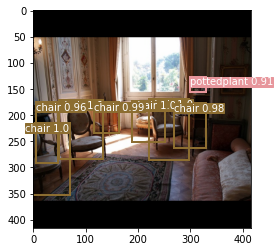

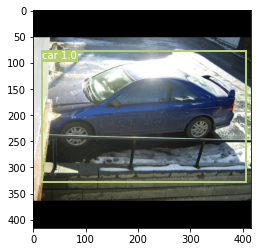

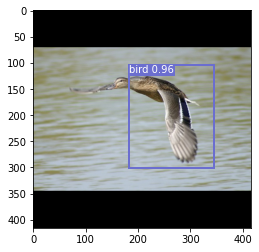

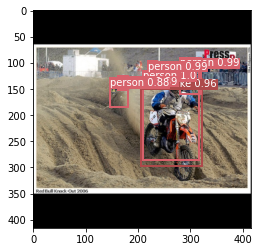

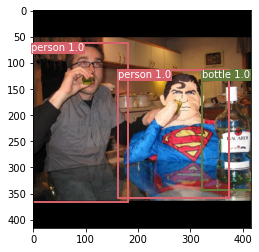

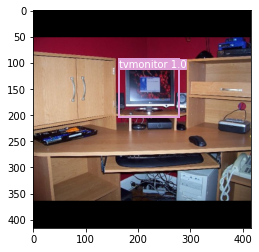

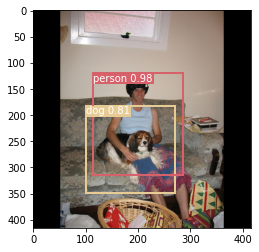

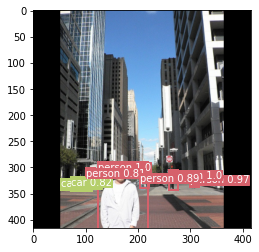

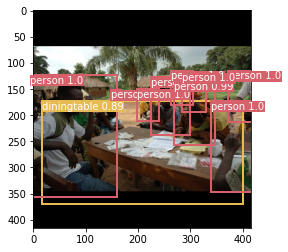

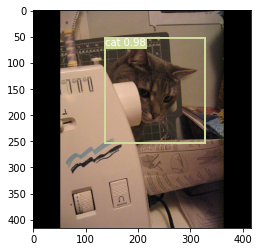

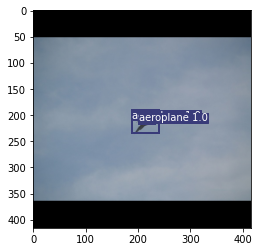

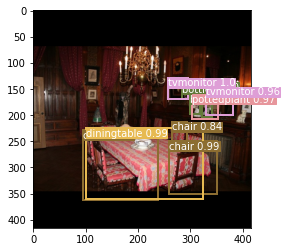

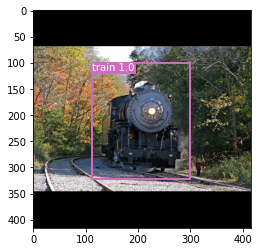

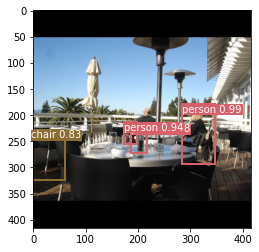

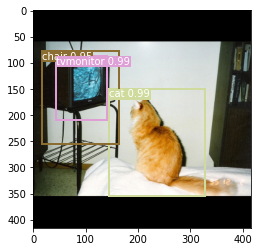

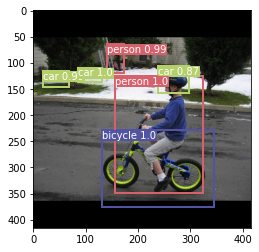

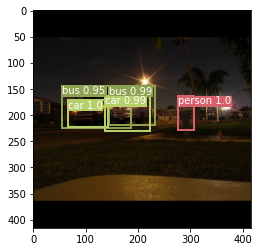

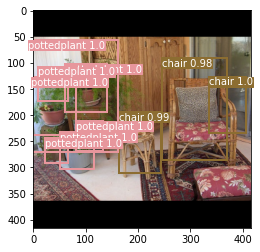

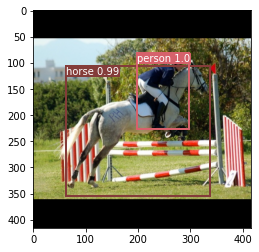

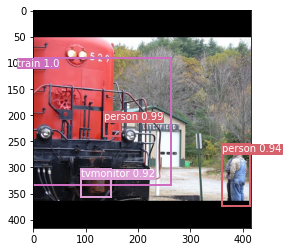

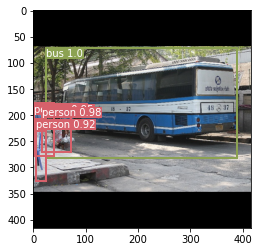

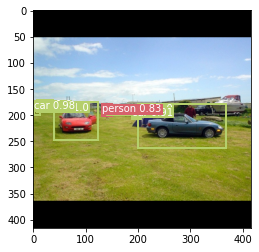

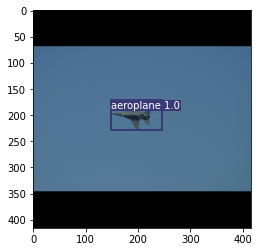

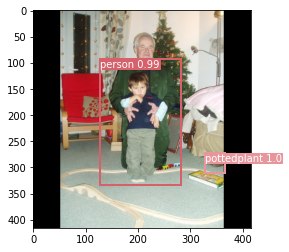

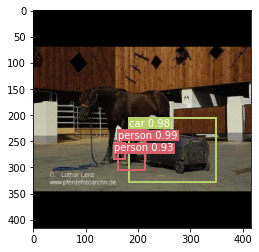

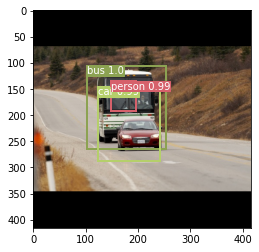

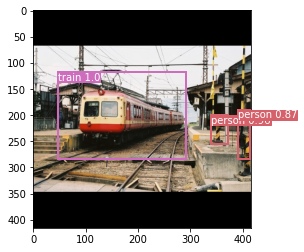

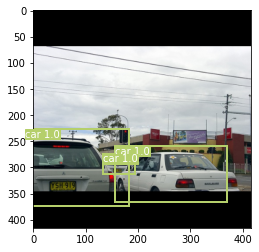

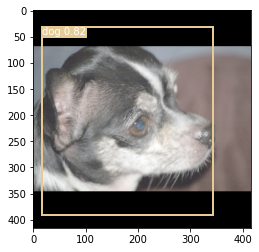

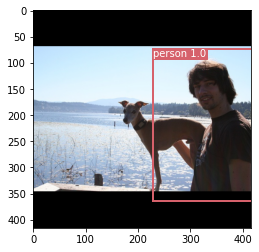

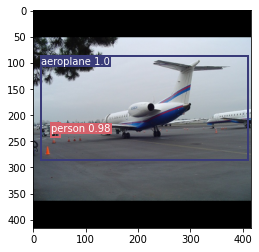

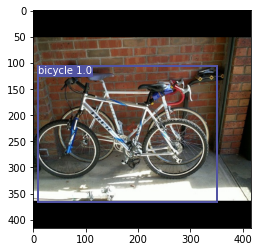

In [40]:
infer(model=model, 
      image_batch=image[:32, :, :], 
      scaled_anchors=scaled_anchors,
      iou_threshold=0.3, 
      object_threshold=0.95, 
      class_threshold=0.8, 
      plot=True)